### Background

Paper - https://arxiv.org/pdf/2010.11929

Architecture Details - ViT-Base

- Layers: 12
- Hidden size: 768
- MLP size: 3072
- Heads: 12
- Params: 86M

Training Details
Train Dataset: JFT - 300 M
- Optimizer:
  - Adam:
      - Beta1: 0.9
      - Beta2: 0.999
      - Weight decay: 0.1
- LR Scheduler: Linear warmup and decay.
- Batch size: 4096
- Dropout

Fine-tuning Details - Higher Resolution
Fine-tune Dataset: CIFAR10
- Optimizer:
  - SGD + Momentum
- Batch size: 512
- Callbacks: Early stopping

Results

Accuracy: 99.5% CIFAR10

- Outperform CNNs with less compute.
- Hybrids (CNN inputs + Transformer) work well for smaller ViT variants but not for larger ones.

### Setup

In [ ]:
# !pip install portalocker==2.6.0
# !pip install torch==2.1.0 torchtext==0.16.0 torchvision==0.16.0 numpy==1.26.4

In [1]:
%%capture
!pip install mlflow
!pip install pyngrok

In [ ]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import mlflow
import subprocess
from pyngrok import ngrok, conf
import getpass

In [ ]:
MLFLOW_TRACKING_URI = "sqlite:///mlflow.db"
subprocess.Popen(["mlflow", "ui", "--backend-store-uri", MLFLOW_TRACKING_URI])

In [ ]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)
# mlflow will create an experiment if it doesn't exist
mlflow.set_experiment("Paper-Replication-ViT")

In [ ]:
print("Enter your authtoken, which can be copied from https://dashboard.ngrok.com/auth")
conf.get_default().auth_token = getpass.getpass()
port=5000
public_url = ngrok.connect(port).public_url
print(f' * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{port}\"')

### Data

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [ ]:
# 1 -- Linux
# 2 -- MacOS
# 3 -- Command Prompt on Windows
# 4 -- manually downloading the data
choice = 1


if choice == 1:
    !wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
elif choice == 2 or choice ==3:
    !curl http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz --output cifar-10-python.tar.gz
else:
    print('Please manually download the data from http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz and put it under the datasets folder.')
!tar -xzvf cifar-10-python.tar.gz

if choice==3:
    !del cifar-10-python.tar.gz
else:
    !rm cifar-10-python.tar.gz

In [ ]:
from six.moves import cPickle as pickle
import numpy as np
import os
from imageio import imread
import platform

def load_pickle(f):
    version = platform.python_version_tuple()
    if version[0] == '2':
        return  pickle.load(f)
    elif version[0] == '3':
        return  pickle.load(f, encoding='latin1')
    raise ValueError("invalid python version: {}".format(version))

def load_CIFAR_batch(filename):
  """ load single batch of cifar """
  with open(filename, 'rb') as f:
    datadict = load_pickle(f)
    X = datadict['data']
    Y = datadict['labels']
    X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    Y = np.array(Y)
    return X, Y

def load_CIFAR10(ROOT):
  """ load all of cifar """
  xs = []
  ys = []
  for b in range(1,6):
    f = os.path.join(ROOT, 'data_batch_%d' % (b, ))
    X, Y = load_CIFAR_batch(f)
    xs.append(X)
    ys.append(Y)
  Xtr = np.concatenate(xs)
  Ytr = np.concatenate(ys)
  del X, Y
  Xte, Yte = load_CIFAR_batch(os.path.join(ROOT, 'test_batch'))
  return Xtr, Ytr, Xte, Yte


def get_CIFAR10_data(cifar10_dir, num_training=49000, num_validation=1000, num_test=1000,
                     subtract_mean=True):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for classifiers. These are the same steps as we used for the SVM, but
    condensed to a single function.
    """
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    if subtract_mean:
      mean_image = np.mean(X_train, axis=0)
      X_train -= mean_image
      X_val -= mean_image
      X_test -= mean_image

    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    X_test = X_test.transpose(0, 3, 1, 2).copy()

    return {
      'X_train': X_train, 'y_train': y_train,
      'X_val': X_val, 'y_val': y_val,
      'X_test': X_test, 'y_test': y_test,
    }

In [ ]:
cifar10_dir = './cifar-10-batches-py'

data = get_CIFAR10_data(cifar10_dir, subtract_mean=True)

pix_mean = (0.485, 0.456, 0.406)
pix_std = (0.229, 0.224, 0.225)

for c in range(3):
    data['X_train'][:, c] = (data['X_train'][:, c] / 255 - pix_mean[c]) / pix_std[c]
    data['X_val'][:, c] = (data['X_val'][:, c] / 255 - pix_mean[c]) / pix_std[c]
    data['X_test'][:, c] = (data['X_test'][:, c] / 255 - pix_mean[c]) / pix_std[c]

for split in ['train', 'val', 'test']:
    print('===\nFor the split {}'.format(split))
    print('shape: {}'.format(data['X_{}'.format(split)].shape))
    print('data value range, min: {}, max: {}\n'.format(data['X_{}'.format(split)].min(), data['X_{}'.format(split)].max()))

### Model Architecture

In [ ]:
class MultiHeadAttention(nn.Module):
    """
    A module that computes multi-head attention given query, key, and value tensors.
    """
    def __init__(self, input_dim: int, num_heads: int):
        """
        Constructor.

        Inputs:
        - input_dim: Dimension of the input query, key, and value. Here we assume they all have
          the same dimensions. But they could have different dimensions in other problems.
        - num_heads: Number of attention heads
        """
        super(MultiHeadAttention, self).__init__()

        assert input_dim % num_heads == 0

        self.input_dim = input_dim
        self.num_heads = num_heads
        self.dim_per_head = input_dim // num_heads

        self.W_k = torch.nn.Linear(self.input_dim, self.input_dim)
        self.W_q = torch.nn.Linear(self.input_dim, self.input_dim)
        self.W_v = torch.nn.Linear(self.input_dim, self.input_dim)
        self.W_o = torch.nn.Linear(self.input_dim, self.input_dim)



    def forward(self, query: torch.Tensor, key: torch.Tensor, value: torch.Tensor, mask: torch.Tensor=None):
        """
        Compute the attended feature representations.

        Inputs:
        - query: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - key: Tensor of the shape BxLxC
        - value: Tensor of the shape BxLxC
        - mask: Tensor indicating where the attention should *not* be performed
        """
        b = query.shape[0]

        dot_prod_scores = None
        q = self.W_q(query)
        q = q.reshape((q.shape[0], q.shape[1],self.dim_per_head, self.num_heads))
        q = q.permute((0,3,1,2))
        q = q.reshape((-1, q.shape[2], q.shape[3]))
        k = self.W_k(key)
        k = k.reshape((k.shape[0], k.shape[1],self.dim_per_head, self.num_heads))
        k = k.permute((0,3,1,2))
        k = k.reshape((-1, k.shape[2], k.shape[3]))
        v = self.W_v(value)
        v = v.reshape((v.shape[0], v.shape[1],self.dim_per_head, self.num_heads))
        v = v.permute((0,3,1,2))
        v = v.reshape((-1, v.shape[2], v.shape[3]))
        dot_prod_scores = torch.matmul(q, k.permute(0,2,1))/math.sqrt(self.dim_per_head)
        dot_prod_scores = dot_prod_scores.reshape((b, self.num_heads,dot_prod_scores.shape[1], dot_prod_scores.shape[2]))

        if mask is not None:
            dot_prod_scores = dot_prod_scores.masked_fill(mask == 0, -1e9)

        out = None
        dot_prod_scores = dot_prod_scores.reshape((-1,dot_prod_scores.shape[2], dot_prod_scores.shape[3]))
        attention_scores = torch.nn.functional.softmax(dot_prod_scores, dim=-1)
        out = torch.matmul(attention_scores, v)
        out = out.reshape((b, self.num_heads,out.shape[1], out.shape[2]))
        out = out.permute((0, 2, 1, 3))
        out = out.reshape((out.shape[0],out.shape[1],-1))
        out = self.W_o(out)
        return out

In [ ]:
class FeedForwardNetwork(nn.Module):
    """
    A simple feedforward network. Essentially, it is a two-layer fully-connected
    neural network.
    """
    def __init__(self, input_dim, ff_dim, dropout):
        """
        Inputs:
        - input_dim: Input dimension
        - ff_dim: Hidden dimension
        """
        super(FeedForwardNetwork, self).__init__()
        self.l1 = torch.nn.Linear(input_dim, ff_dim)
        self.l2 = torch.nn.Linear(ff_dim, input_dim)
        self.dropout = torch.nn.Dropout(dropout)
        self.relu = torch.nn.GELU()

    def forward(self, x: torch.Tensor):
        """
        Input:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
         and C is the channel dimension

        Return:
        - y: Tensor of the shape BxLxC
        """

        y = None
        b, l, d = x.shape[0], x.shape[1], x.shape[2]
        x = x.reshape((-1, d))
        x = self.l1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.l2(x)
        x = x.reshape((b, l, d))
        return x


In [ ]:
class TransformerEncoderCell(nn.Module):
    """
    A single cell (unit) for the Transformer encoder.
    """
    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, dropout: float):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoderCell, self).__init__()

        self.mha = MultiHeadAttention(input_dim, num_heads)
        self.dropout = torch.nn.Dropout(p=dropout)
        self.layer_norm = torch.nn.LayerNorm(input_dim)
        self.ffnn = FeedForwardNetwork(input_dim, ff_dim, dropout)

    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - mask: Tensor for masking in the multi-head attention
        """

        y = None
        Xprev = x
        Xout = self.layer_norm(Xprev)
        Xout = self.mha(Xout, Xout, Xout, mask)
        Xout = self.dropout(Xout)
        Xout = Xout+Xprev

        Xprev = Xout
        Xout= self.layer_norm(Xprev)
        Xout= self.ffnn(Xout)
        Xout = self.dropout(Xout)
        Xout = Xout+Xprev
        return Xout

In [ ]:
class TransformerEncoder(nn.Module):
    """
    A full encoder consisting of a set of TransformerEncoderCell.
    """

    def __init__(self, input_dim: int, num_heads: int, ff_dim: int, num_cells: int, dropout: float=0.1):
        """
        Inputs:
        - input_dim: Input dimension for each token in a sequence
        - num_heads: Number of attention heads in a multi-head attention module
        - ff_dim: The hidden dimension for a feedforward network
        - num_cells: Number of TransformerEncoderCells
        - dropout: Dropout ratio for the output of the multi-head attention and feedforward
          modules.
        """
        super(TransformerEncoder, self).__init__()
        self.encoder_stack = torch.nn.ModuleList([TransformerEncoderCell(input_dim, num_heads, ff_dim, dropout) for i in range(num_cells)])
        self.norm = torch.nn.LayerNorm(input_dim)

    def forward(self, x: torch.Tensor, mask: torch.Tensor=None):
        """
        Inputs:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - mask: Tensor for masking in the multi-head attention

        Return:
        - y: Tensor of the shape of BxLxC, which is the normalized output of the encoder
        """

        y = None
        for encoder in self.encoder_stack:
            x = encoder(x, mask)
        return x


In [ ]:
import numpy as np
from torch import nn
class PositionalEncoding(nn.Module):
    """
    A module that adds positional encoding to each of the token's features.
    So that the Transformer is position aware.
    """
    def __init__(self, input_dim: int, max_len: int=10000):
        """
        Inputs:
        - input_dim: Input dimension about the features for each token
        - max_len: The maximum sequence length
        """
        super(PositionalEncoding, self).__init__()

        self.input_dim = input_dim

    def forward(self, x, max_length=10000):
        """
        Compute the positional encoding and add it to x.

        Input:
        - x: Tensor of the shape BxLxC, where B is the batch size, L is the sequence length,
          and C is the channel dimension
        - max_length: maximum sequence length the positional encoding can handle

        Return:
        - x: Tensor of the shape BxLxC, with the positional encoding added to the input
        """
        seq_len = x.shape[1]
        input_dim = x.shape[2]

        pe = torch.zeros_like(x)
        for position_index in range(seq_len):
            for dimension_index in range(input_dim//2):
                pe[:,position_index, 2*dimension_index] = np.sin(position_index/np.power(max_length, 2*dimension_index/input_dim))
                pe[:,position_index, 2*dimension_index+1] = np.cos(position_index/np.power(max_length, 2*dimension_index/input_dim))
        x = x + pe.to(x.device)
        return x

In [ ]:
# Sanity check
import torch
x = torch.randn(1, 100, 20)
pe = PositionalEncoding(20)
y = pe(x)
assert len(x.shape) == len(y.shape)
for dim_x, dim_y in zip(x.shape, y.shape):
    assert dim_x == dim_y

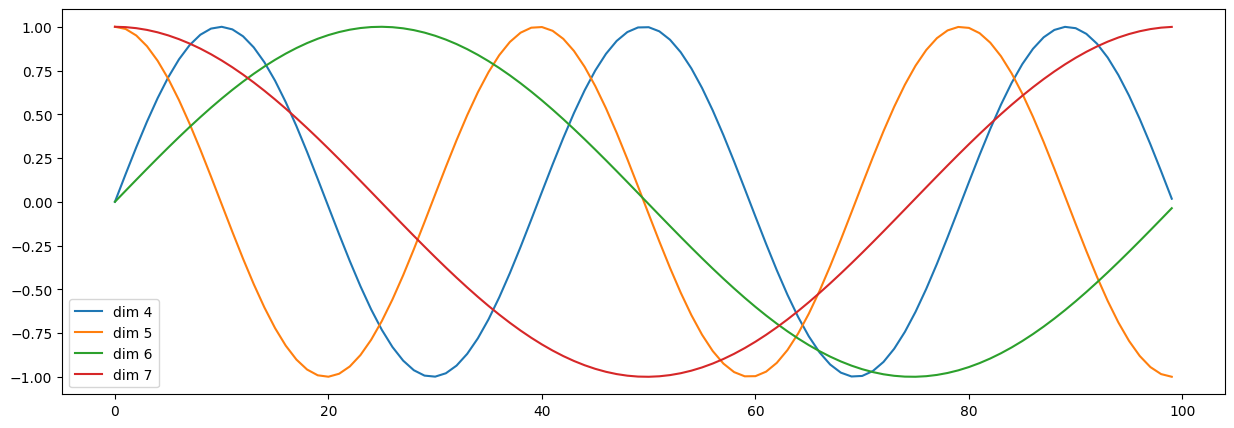

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 5))
pe = PositionalEncoding(20, 0)
y = pe.forward((torch.zeros(1, 100, 20)))
plt.plot(np.arange(100), y[0, :, 4:8].data.numpy())
plt.legend(["dim %d"%p for p in [4,5,6,7]])

In [ ]:
class TransformerClassifier(nn.Module):
    """
    A Transformer-based text classifier.
    """
    def __init__(self,
            input_dim: int, seq_len:int, embed_dim: int, num_heads: int, trx_ff_dim: int,
            num_trx_cells: int, num_class: int, dropout: float=0.1, pad_token: int=0
        ):
        """
        Inputs:
        - vocab_size: Vocabulary size, indicating how many tokens we have in total.
        - embed_dim: The dimension of word embeddings
        - num_heads: Number of attention heads in a multi-head attention module
        - trx_ff_dim: The hidden dimension for a feedforward network
        - num_trx_cells: Number of TransformerEncoderCells
        - dropout: Dropout ratio
        - pad_token: The index of the padding token.
        """
        super(TransformerClassifier, self).__init__()
        self.class_token = torch.nn.Parameter(torch.randn(1, 1, embed_dim))
        self.visual_embedding = torch.nn.Linear(input_dim, embed_dim)
        self.positional_encoding = PositionalEncoding(embed_dim)
        self.trx_encoder = TransformerEncoder(embed_dim, num_heads, trx_ff_dim, num_trx_cells, dropout)
        self.classifier = torch.nn.Linear(embed_dim, num_class)
    def forward(self, patches, mask=None):
        """
        Inputs:
        - text: Tensor with the shape of BxL, containing the indexes of each word in
          the vocabulary, which will be converted into word embeddings with the shape
          of BxLxC
        - mask: Tensor for masking in the multi-head attention

        Return:
        - logits: Tensor with the shape of BxK, where K is the number of classes
        """

        embedded = self.visual_embedding(patches)
        embedded = torch.cat([self.class_token.expand(embedded.shape[0],-1,-1), embedded],dim=1)
        x = self.positional_encoding(embedded)
        x = self.trx_encoder(x, mask)
        x = x[:,0,:]
        logits = self.classifier(x)
        return logits

### Visual Tokens

In [ ]:
def create_patches(images, total_num_patches):
    num_patches = int(np.sqrt(total_num_patches))
    patch_size = images.shape[-1]//num_patches
    patches = []
    for j in range(1, num_patches+1):
        height_start_idx = (j-1)*patch_size
        height_end_idx = j*patch_size
        for i in range(1,num_patches+1):
            width_start_idx = (i-1)*patch_size
            width_end_idx = i*patch_size
            patch = images[:,:,height_start_idx:height_end_idx,width_start_idx:width_end_idx]
            patch = patch.reshape(patch.shape[0],-1)
            patches.append(patch)
    patches = np.array(patches)
    patches = patches.transpose(1,0,-1)
    return patches
patches = create_patches(data['X_test'][0:5], total_num_patches=64)
print(patches.shape)

(5, 64, 48)


3 Cat


(np.float64(-0.5), np.float64(31.5), np.float64(31.5), np.float64(-0.5))

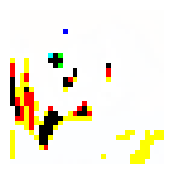

In [ ]:
from PIL import Image
print(data['y_test'][0],'Cat')
img = Image.fromarray(data['X_test'][0].transpose(1,2,0).astype(np.uint8))
plt.figure(figsize=(2,2))
plt.imshow(img)
plt.axis('off')

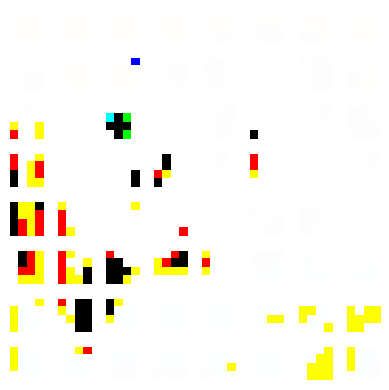

In [ ]:
img = np.array(img).transpose(2,0,1).reshape(1,3,32,32)
patches = create_patches(img, total_num_patches=64)[0,:,:].reshape(64,3,4,4)
fig, ax = plt.subplots(nrows=8, ncols=8,figsize=(4,4))
count=0
for i in range(8):
    for j in range(8):
        ax[i,j].imshow(patches[count,:,:,:].transpose(1,2,0))
        ax[i,j].axis('off')
        count+=1

plt.tight_layout()
plt.show()

### Train Loop

In [ ]:
def set_up_cifar10_data_loader(images, labels, batch_size, total_num_patches=64, shuffle=True):
    dataset = torch.utils.data.TensorDataset(torch.Tensor(create_patches(images, total_num_patches)), torch.Tensor(labels))
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2)
    return data_loader

In [ ]:
def test_model(model, data_loader):
    """
    Compute accuracy of the model.

    Inputs:
      - model: A CNN implemented in PyTorch
      - data_loader: A data loader that will provide batched images and labels
    """

    model.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for batch_data in data_loader:
            images, labels = batch_data
            images = images.cuda()
            labels = labels.cuda()

            predicted = None
            logits = model(images)
            predicted = torch.argmax(logits, dim=-1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct // total
    return acc

In [ ]:
def train_val_model(model, train_data_loader, val_data_loader, loss_fn, optimizer, lr_scheduler, num_epochs, grad_norm_clip, patience=5, print_freq=50):
    """
    Training and validating a CNN model using PyTorch.

    Inputs:
      - model: A CNN implemented in PyTorch
      - data_loader: A data loader that will provide batched images and labels
      - loss_fn: A loss function (e.g., cross entropy loss)
      - lr_scheduler: Learning rate scheduler
      - num_epochs: Number of epochs in total
      - print_freq: Frequency to print training statistics

    Output:
      - model: Trained CNN model
    """
    best_acc = float('-inf')
    patience_count = 0
    for epoch_i in range(num_epochs):
        model.train()

        running_loss = 0.0
        running_total = 0.0
        running_correct = 0.0
        for i, batch_data in enumerate(train_data_loader):
            images, labels = batch_data
            images = images.cuda()
            labels = labels.cuda()

            predicted = None
            labels = labels.long()
            optimizer.zero_grad()
            logits = model(images)
            predicted = torch.argmax(logits, dim=-1)
            loss = loss_fn(logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_norm_clip)
            optimizer.step()
            running_loss += loss.item()
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()
            if i % print_freq == 0:
                running_loss = running_loss / print_freq
                running_acc = running_correct / running_total * 100
                last_lr = lr_scheduler.get_last_lr()[0]
                print(f'Epoch {epoch_i + 1}/{num_epochs} -- | Step {i + 1:5d}/{len(train_data_loader)} | Loss: {running_loss:.3f} | Accuracy: {running_acc:.2f}% | LR: {last_lr:.5f} |')
                mlflow.log_metric("train_loss", running_loss, step=epoch_i * len(train_data_loader) + i)
                mlflow.log_metric("train_accuracy", running_acc, step=epoch_i * len(train_data_loader) + i)
                mlflow.log_metric("learning_rate", last_lr, step=epoch_i * len(train_data_loader) + i)
                running_loss = 0.0
                running_total = 0.0
                running_correct = 0.0

        lr_scheduler.step()

        val_acc = test_model(model, val_data_loader)
        mlflow.log_metric("val_accuracy", val_acc, step=epoch_i+1)
        if val_acc > best_acc:
            best_acc = val_acc
            patience_count-=1
        else:
            patience_count+=1
        if patience_count>=patience:
            print(f'Early stopping tirggered at epoch - {epoch_i+1} | Best validation accuracy {best_acc:.2f}% ')
            mlflow.log_metric("early_stopping_epoch", epoch_i + 1)
            break
        print(f'Epoch {epoch_i + 1}/{num_epochs} -- | Validation Accuracy: {val_acc:.2f}% |')

    return model

In [ ]:
from torch.utils.data.dataset import random_split

assert torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

run_id = 1
epochs = 142
num_class = 10
lr = 3e-4
weight_decay = 1e-3
batch_size = 1024
step_size = 10
# T_max = 100
gamma = 0.9
momentum = 0.9
seq_len = total_num_patches = 64
num_patches = int(np.sqrt(total_num_patches))
channels = 3
spatial_dim = 32
input_dim = channels*(spatial_dim//num_patches)*(spatial_dim//num_patches)
embed_dim = 296
ff_dim = embed_dim*4
num_heads = 8
num_trx_cells = 8

gradient_norm_clip = 10.0

dropout = 0.1

model = TransformerClassifier(input_dim, seq_len, embed_dim, num_heads, ff_dim, num_trx_cells, num_class, dropout)

loss_func = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size, gamma)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
model = model.cuda()
num_params = sum(p.numel() for p in model.parameters())
print('Number of parameters: {:.3f}M'.format(num_params / 1000000))

train_loader = set_up_cifar10_data_loader(data['X_train'], data['y_train'], batch_size, total_num_patches, shuffle=True)
print("There are {} batches in the training set.".format(len(train_loader)))

val_loader = set_up_cifar10_data_loader(data['X_val'], data['y_val'], batch_size, total_num_patches, shuffle=False)
print("There are {} batches in the validation set.".format(len(val_loader)))

test_loader = set_up_cifar10_data_loader(data['X_test'], data['y_test'], batch_size, total_num_patches, shuffle=False)
print("There are {} batches in the testing set.".format(len(test_loader)))

print('-'*100)
with mlflow.start_run():
    mlflow.log_param("device", str(device))
    mlflow.log_param("epochs", epochs)
    mlflow.log_param("num_class", num_class)
    mlflow.log_param("learning_rate", lr)
    mlflow.log_param("weight_decay", weight_decay)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("step_size", step_size)
    mlflow.log_param("gamma", gamma)
    mlflow.log_param("momentum", momentum)
    mlflow.log_param("seq_len", seq_len)
    mlflow.log_param("num_patches", num_patches)
    mlflow.log_param("channels", channels)
    mlflow.log_param("spatial_dim", spatial_dim)
    mlflow.log_param("input_dim", input_dim)
    mlflow.log_param("embed_dim", embed_dim)
    mlflow.log_param("ff_dim", ff_dim)
    mlflow.log_param("num_heads", num_heads)
    mlflow.log_param("num_trx_cells", num_trx_cells)
    mlflow.log_param("gradient_norm_clip", gradient_norm_clip)
    mlflow.log_param("dropout", dropout)
    mlflow.log_param("optimizer", optimizer.__class__.__name__)
    mlflow.log_param("scheduler", scheduler.__class__.__name__)
    mlflow.log_param("num_parameters", num_params)
    mlflow.log_param("train_batches", len(train_loader))
    mlflow.log_param("val_batches", len(val_loader))
    mlflow.log_param("test_batches", len(test_loader))

    mlflow.log_param("model_architecture", str(model))
    model = train_val_model(model, train_loader, val_loader, loss_func, optimizer, scheduler, epochs, gradient_norm_clip)

    test_acc = test_model(model, test_loader)
    print(f"| Testing accuracy: {test_acc:.3f} |")
    mlflow.log_metric("test_accuracy", test_acc)
    mlflow.pytorch.log_model(model, f"Run - {run_id}")

cuda
Number of parameters: 8.456M
There are 48 batches in the training set.
There are 1 batches in the validation set.
There are 1 batches in the testing set.
----------------------------------------------------------------------------------------------------
Epoch 1/142 -- | Step     1/48 | Loss: 0.052 | Accuracy: 11.91% | LR: 0.00030 |
Epoch 1/142 -- | Validation Accuracy: 33.00% |
Epoch 2/142 -- | Step     1/48 | Loss: 0.039 | Accuracy: 29.10% | LR: 0.00030 |
Epoch 2/142 -- | Validation Accuracy: 45.00% |
Epoch 3/142 -- | Step     1/48 | Loss: 0.030 | Accuracy: 46.00% | LR: 0.00030 |
Epoch 3/142 -- | Validation Accuracy: 52.00% |
Epoch 4/142 -- | Step     1/48 | Loss: 0.027 | Accuracy: 51.07% | LR: 0.00030 |
Epoch 4/142 -- | Validation Accuracy: 59.00% |
Epoch 5/142 -- | Step     1/48 | Loss: 0.022 | Accuracy: 60.64% | LR: 0.00030 |
Epoch 5/142 -- | Validation Accuracy: 60.00% |
Epoch 6/142 -- | Step     1/48 | Loss: 0.021 | Accuracy: 64.16% | LR: 0.00030 |
Epoch 6/142 -- | Validati